In [1]:
from torch.utils.data import Dataset, DataLoader
import glob
import random
import models.dataset as ds
import models.wiener_model as wm
from models.unet import Unet
import numpy as np
import torch
import helper as hp
import cv2
from scipy import signal
from skimage.metrics import structural_similarity
import statistics
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='inferno')
device = 'cuda:1'

In [2]:
filepath_save = '/media/RAIDHDD/s7222254/Python/MultiWienerNet/pytorch/saved_data/2D_multiwiener_dlp_256_AugDigits_l2_0/' 

In [3]:
filepath_gt = '/media/RAIDHDD/s7222254/Python/Data/DATA_dlp_AugDigits24mu_shift_200_256_256/Truth/' 
filepath_meas = '/media/RAIDHDD/s7222254/Python/Data/DATA_dlp_AugDigits24mu_shift_200_256_256/Meas/' 


filepath_all=glob.glob(filepath_gt+'*')
#random.Random(8).shuffle(filepath_all)
print('total number of images',len(filepath_all))
total_num_images = len(filepath_all)
num_test = 0.2 # 20% test
filepath_train=filepath_all[0:int(total_num_images*(1-num_test))]
filepath_test=filepath_all[int(total_num_images*(1-num_test)):]

print('training images:', len(filepath_train), 
      'testing images:', len(filepath_test))

dataset_test = ds.MiniscopeDataset_2D(filepath_test, filepath_meas, transform = ds.ToTensor2d())
    


dataloader_test = DataLoader(dataset_test, batch_size=1,
                        shuffle=False, num_workers=1)

total number of images 10000
training images: 8000 testing images: 2000


In [4]:
unet_model = Unet(n_channel_in=9, n_channel_out=1, residual=False, down='conv', up='tconv', activation='selu').to(device)
psfs=np.ones((9,512,512))
Ks=np.ones((9,1,1))
wiener_model=wm.WienerDeconvolution3D(psfs,Ks).to(device)
model=wm.MyEnsemble(wiener_model,unet_model)

model.load_state_dict(torch.load(filepath_save + 'model.pt'))


<All keys matched successfully>

PSNR mean: 21.88 dB, median: 20.99 dB, std: 3.66 dB
SSIM mean: 0.7497 , median: 0.7406 , std: 0.121 
CC mean: 0.6979 , median: 0.7043 , std: 0.09288 



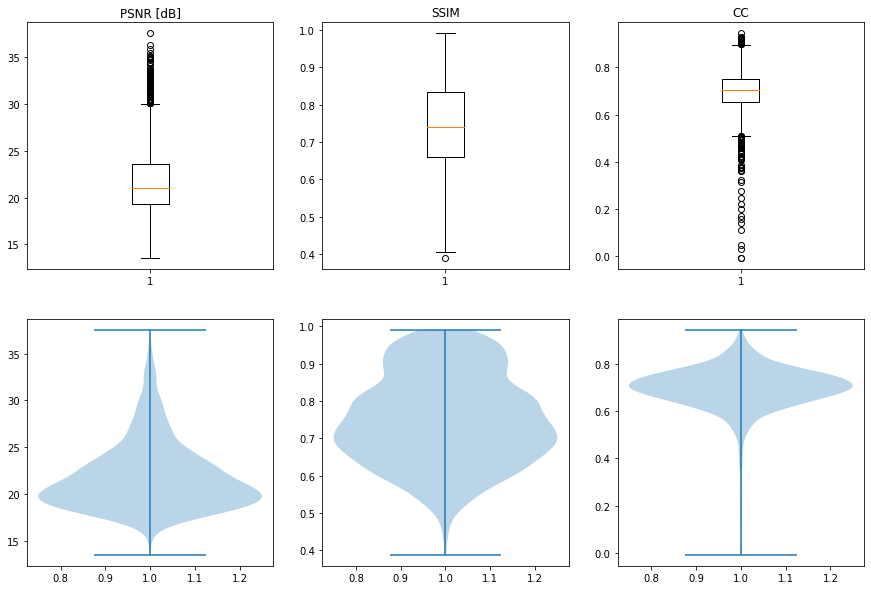

In [5]:
eval_test = {'psnr_test': [], 'ssim_test': [], 'corr_test': []}


for i_batch, sample_batched in enumerate(dataloader_test):
    #with torch.no_grad():

    out, wiener_out = model(sample_batched['meas'].to(device))
                    
    out_np = out.detach().cpu().numpy()[0][0]
    gt_np = sample_batched['im_gt'].detach().cpu().numpy()[0][0]
    
    eval_test['psnr_test'].append(cv2.PSNR(255*out_np,255*gt_np))
    eval_test['ssim_test'].append(structural_similarity(out_np,gt_np,data_range=1,gaussian_weights=True,sigma=1.5))
    eval_test['corr_test'].append(hp.corr2(out_np,gt_np))
    
eval_test['psnr_mean'] = statistics.mean(eval_test['psnr_test'])
eval_test['psnr_median'] = statistics.median(eval_test['psnr_test'])
eval_test['psnr_std'] = statistics.pstdev(eval_test['psnr_test'])

eval_test['ssim_mean'] = statistics.mean(eval_test['ssim_test'])
eval_test['ssim_median'] = statistics.median(eval_test['ssim_test'])
eval_test['ssim_std'] = statistics.pstdev(eval_test['ssim_test'])

eval_test['corr_mean'] = statistics.mean(eval_test['corr_test'])
eval_test['corr_median'] = statistics.median(eval_test['corr_test'])
eval_test['corr_std'] = statistics.pstdev(eval_test['corr_test'])

print('PSNR mean:', format(eval_test['psnr_mean'], '.4g'), 'dB, median:', format(eval_test['psnr_median'], '.4g'), 'dB, std:', format(eval_test['psnr_std'], '.4g'), 'dB')
print('SSIM mean:', format(eval_test['ssim_mean'], '.4g'), ', median:', format(eval_test['ssim_median'], '.4g'), ', std:', format(eval_test['ssim_std'], '.4g'), '')
print('CC mean:', format(eval_test['corr_mean'], '.4g'), ', median:', format(eval_test['corr_median'], '.4g'), ', std:', format(eval_test['corr_std'], '.4g'), '\n')
    
f, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].boxplot(eval_test['psnr_test'])
ax[0].title.set_text('PSNR [dB], Median: ' + format(eval_test['psnr_median'], '.4g') + 'dB')
ax[1].boxplot(eval_test['ssim_test'])
ax[1].title.set_text('SSIM, Median: ' + format(eval_test['ssim_median'], '.4g'))
ax[2].boxplot(eval_test['corr_test'])
ax[2].title.set_text('CC, Median: ' + format(eval_test['corr_median'], '.4g'))
ax[0].violinplot(eval_test['psnr_test'])
ax[1].violinplot(eval_test['ssim_test'])
ax[2].violinplot(eval_test['corr_test'])
#plt.savefig(filepath_save + 'eval.png')
plt.show()

#savemat(filepath_save + 'eval_test.mat',eval_test)

1348


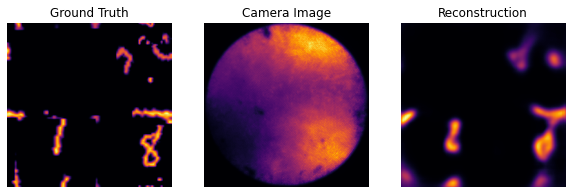

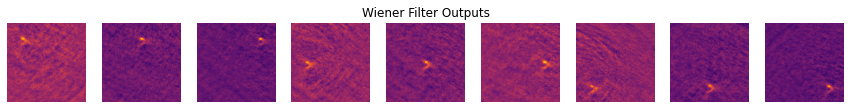

In [22]:
i_ = 1348#random.randint(0,1999)
print(i_)
sample = dataset_test.__getitem__(i_)
meas_np = hp.to_np(sample_batched['meas'])
sample['meas'] = sample['meas'].unsqueeze(0)
sample['im_gt'] = sample['im_gt'].unsqueeze(0)
out, wiener_out = model(sample['meas'].to(device))
out_np = out.detach().cpu().numpy()[0][0]
gt_np = sample['im_gt'].detach().cpu().numpy()[0][0]
meas_np = sample['meas'].detach().cpu().numpy()[0][0]

f, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(gt_np, vmin = 0, vmax = 1)
ax[0].set_axis_off()
ax[0].set_title('Ground Truth')
ax[1].imshow(meas_np, vmin = 0, vmax = 1)
ax[1].set_axis_off()
ax[1].set_title('Camera Image')
ax[2].imshow(out_np, vmin = 0, vmax = 1)
ax[2].set_axis_off()
ax[2].set_title('Reconstruction')
plt.savefig(filepath_save + 'rec_' + str(i_) + '.png')

f, axs = plt.subplots(1, 9, figsize=(15,15))
plt.axis('off')
axs[0].imshow(wiener_out[0,0,:,:].detach().cpu().numpy())
axs[0].set_axis_off()
axs[1].imshow(wiener_out[0,1,:,:].detach().cpu().numpy())
axs[1].set_axis_off()
axs[2].imshow(wiener_out[0,2,:,:].detach().cpu().numpy())
axs[2].set_axis_off()
axs[3].imshow(wiener_out[0,3,:,:].detach().cpu().numpy())
axs[3].set_axis_off()
axs[4].imshow(wiener_out[0,4,:,:].detach().cpu().numpy())
axs[4].set_axis_off()
axs[4].set_title('Wiener Filter Outputs')
axs[5].imshow(wiener_out[0,5,:,:].detach().cpu().numpy())
axs[5].set_axis_off()
axs[6].imshow(wiener_out[0,6,:,:].detach().cpu().numpy())
axs[6].set_axis_off()
axs[7].imshow(wiener_out[0,7,:,:].detach().cpu().numpy())
axs[7].set_axis_off()
axs[8].imshow(wiener_out[0,8,:,:].detach().cpu().numpy())
axs[8].set_axis_off()
#plt.savefig(filepath_save + 'wienerout_' + str(i_) + '.png')